# Project: Investigate a Dataset - Medical Appointment No Shows

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

In this notebook, I will be working with the Medical Appointment No Shows dataset, which contains over 100,000 medical appointments from Brazil throughout 2016. The dataset aims to predict whether a patient will attend their scheduled appointment.

Column list:

| Index | Column name | Description | Significance |
| --- | --- | --- | --- |
| 0 | PatientID | ID of the patient | Not significant |
| 1 | AppointmentID | ID of the appointment | Not significant |
| 2 | Gender | Male (M) / Female (F) | Significant |
| 3 | ScheduledDay | The date of scheduling the appointment | Significant |
| 4 | AppointmentDay | The date of the actual appointment |  Significant |
| 5 | Age | The age of the patient | Significant |
| 6 | Neighbourhood | The neighbourhood where the appointment takes place | Significant |
| 7 | Scholarship |  True (1) / False (0) | Significant |
| 8 | Hipertension |  True (1) / False (0) | Significant |
| 9 | Diabetes |  True (1) / False (0) | Significant |
| 10 | Alcholism | True (1) / False (0) | Significant |
| 11 | Handcap |  | Significant |
| 12 | SMS_recieved | True (1) / False (0) | Significant |
| 13 | No-show | True (1) / False (0) | Significant |



### Question(s) for Analysis

I'll answer following questions:

1. Which day of appointmentday has the highest no-show ratio?
2. Does the age of a patient influence decision of not showing at the appointment?
3. Is there a mutual dependence between missing the appointment and the time gap between the appointment date and the date it was scheduled?
4.  What are top 3 factors influencing no shows among numeric factors?

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm 
from sklearn.feature_selection import mutual_info_classif

<a id='wrangling'></a>
## Data Wrangling

In [63]:
# Load dataset
df = pd.read_csv('Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [64]:
# Size of the dataset
df.shape

(110527, 14)

In the dataset there are 110527 rows and 14 columns

In [65]:
# Inspect data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [66]:
df.AppointmentID.nunique(), df.PatientId.nunique()

(110527, 62299)

In [67]:
# describe numeric data data
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The dataset contains 110527 records. Minimum value for age is -1. I treat it as incorrect data and will replace with 0 value. Almost 10% of appointments are appointments within scholarship and near 205 of patients have hipertension. 7% of patients are diabetes and 3% of patients abuse alcohol or are addicted to alcohol. 32% of patients received an SMS. 2% of pateints are handicap people.

In [68]:
# Inspect missing values and possibly errant data
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [69]:
# check duplicated data
df.duplicated().sum()

0

In [70]:
# check age column
df['Age'].value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

In [71]:
columns = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']

for column in columns:
    print(df[column].value_counts())

0    99666
1    10861
Name: Scholarship, dtype: int64
0    88726
1    21801
Name: Hipertension, dtype: int64
0    102584
1      7943
Name: Diabetes, dtype: int64
0    107167
1      3360
Name: Alcoholism, dtype: int64
0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64
0    75045
1    35482
Name: SMS_received, dtype: int64


In [72]:
#  check values for object/string columns
columns = ['Neighbourhood', 'No-show', 'Gender']

for column in columns:
    print(column, df[column].unique())

Neighbourhood ['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA' 'CRUZAMENTO' 'ILHA DO PRÍNCIPE' 'ROM

There are numeric and string (object) values in the dataset. Findings:

1. ScheduledDay and AppointmentDay need to be changed into datatime formats. 
2. I will delete AppointmentID as I don't need it in the analysis. 
3. I will keep PatientId as there are multiple rows for one patient. Maye there are patients that often do not show on scheduled appointment? 
4. I will keep Gender as binary 0/1 value. F = 1, M = 0
5. I will rename No-show as NoShow and change it into binary 0/1 value.
6. I will change Age -1 value into 0 value
7. I will keep Neighbourhood as category variable


### Data Cleaning

In [73]:
# change ScheduledDay and AppointmentDay into data format. I will keep just date

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format='%Y-%m-%dT%H:%M:%SZ').dt.normalize()
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format='%Y-%m-%dT%H:%M:%SZ')

In [74]:
# drop AppointmentID
df.drop('AppointmentID', axis=1, inplace=True)

In [75]:
# change Neighbourhood into category type
columns = ['Neighbourhood']
for column in columns:
    df[column] = df[column].astype('category')

In [76]:
df['Gender'].replace({'M': 0, 'F': 1}, inplace=True)

In [77]:
# change No-show, Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, Neighbourhood into bool types.
# No-show:
# 1 - no-show
# 0 - patient showed on the appointment
df['No-show'].replace({'No': 0, 'Yes': 1}, inplace=True)

df.rename(columns={"No-show": "NoShow"}, inplace = True)

In [78]:
# change Age -1 value into 0 value
df['Age'].replace({-1: 0}, inplace=True)

In [79]:
df['Age'].value_counts()

0      3540
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: int64

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  float64       
 1   Gender          110527 non-null  int64         
 2   ScheduledDay    110527 non-null  datetime64[ns]
 3   AppointmentDay  110527 non-null  datetime64[ns]
 4   Age             110527 non-null  int64         
 5   Neighbourhood   110527 non-null  category      
 6   Scholarship     110527 non-null  int64         
 7   Hipertension    110527 non-null  int64         
 8   Diabetes        110527 non-null  int64         
 9   Alcoholism      110527 non-null  int64         
 10  Handcap         110527 non-null  int64         
 11  SMS_received    110527 non-null  int64         
 12  NoShow          110527 non-null  int64         
dtypes: category(1), datetime64[ns](2), float64(1), int64(9)
memory usage: 10.2 MB


<a id='eda'></a>
## Exploratory Data Analysis


### 1. Which day of AppointmentDay has the highest no-show ratio?

In [81]:
df['Day_of_Appointment'] = df['AppointmentDay'].dt.day_name()

In [82]:
df

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,Day_of_Appointment
0,2.987250e+13,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,Friday
1,5.589978e+14,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,Friday
2,4.262962e+12,1,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,Friday
3,8.679512e+11,1,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,Friday
4,8.841186e+12,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,1,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday
110523,3.596266e+12,1,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday
110524,1.557663e+13,1,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday
110525,9.213493e+13,1,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday


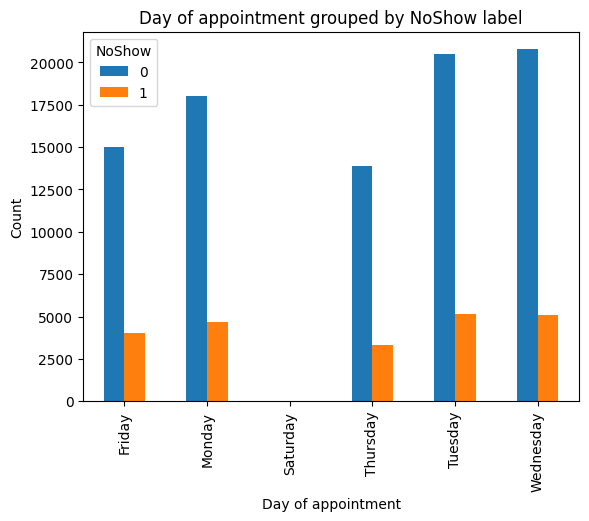

In [83]:
# barplot of 'Day_of_Appointment' by 'NoShow'
df[['Day_of_Appointment', 'NoShow']].groupby(['Day_of_Appointment', 'NoShow']).size().unstack().plot(kind='bar')
plt.title('Day of appointment grouped by NoShow label')
plt.xlabel("Day of appointment")
plt.ylabel("Count")
plt.show()

In [84]:
df_day = pd.pivot_table(df, columns='Day_of_Appointment', values= 'NoShow')

In [85]:
df_day = df_day.melt()
df_day

,Day_of_Appointment,value
0,Friday,0.212261
1,Monday,0.206471
2,Saturday,0.230769
3,Thursday,0.193541
4,Tuesday,0.200936
5,Wednesday,0.196892


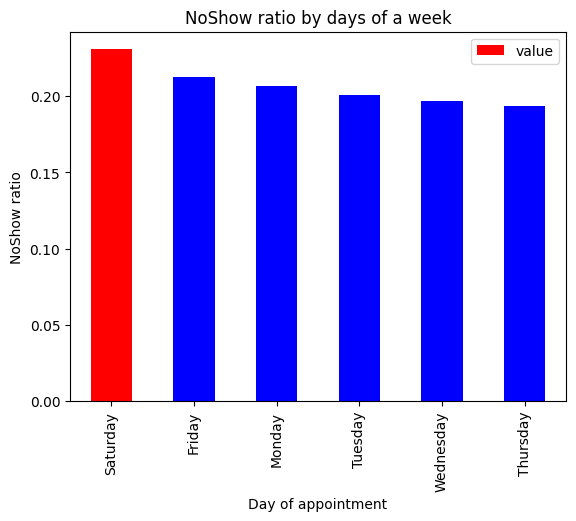

In [86]:
df_day.sort_values(by = 'value', ascending = False).plot(x='Day_of_Appointment', y= 'value', kind = 'bar'
                                                        , color = ['red', 'blue', 'blue', 'blue', 'blue', 'blue'])

plt.title('NoShow ratio by days of a week')
plt.xlabel("Day of appointment")
plt.ylabel("NoShow ratio");


The highest no-show ratio is during the weekend on Saturdays. The second highest no-show ratio is on Fridays. The lowest number of appointments is on Saturday, during the weekend. Most ofetn patients schedule appointments on Wednesdays and Teusdays.

### 2. Does the age of a patient influence decision of not showing at the appointment?

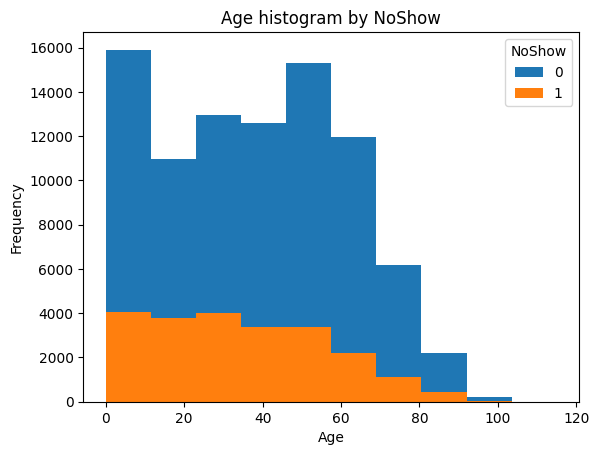

In [87]:
# Age histogram by NoShow 
df.pivot(columns='NoShow').Age.plot.hist()

plt.title('Age histogram by NoShow')
plt.xlabel("Age");

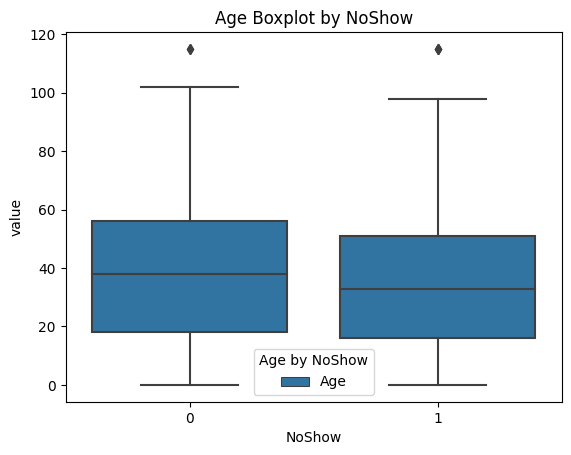

In [88]:
# Boxplot age by Noshow
df_boxplot=pd.melt(df,id_vars=['NoShow'],value_vars=['Age'],var_name='Age by NoShow')
sns.boxplot(x='NoShow',y='value',data=df_boxplot,hue='Age by NoShow')
plt.title('Age Boxplot by NoShow');


In [89]:
print('Age', df['Age'].describe()), 
print('Age & NoShow = 0', df['Age'].where(df['NoShow'] ==0).describe()), 
print('Age & NoShow = 1', df['Age'].where(df['NoShow'] ==1).describe())

Age count    110527.000000
mean         37.088883
std          23.110190
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64
Age & NoShow = 0 count    88208.000000
mean        37.790076
std         23.338860
min          0.000000
25%         18.000000
50%         38.000000
75%         56.000000
max        115.000000
Name: Age, dtype: float64
Age & NoShow = 1 count    22319.000000
mean        34.317667
std         21.965941
min          0.000000
25%         16.000000
50%         33.000000
75%         51.000000
max        115.000000
Name: Age, dtype: float64


In [90]:
# Logistic regression base model to check causation

In [91]:
X = df[['Age']]
y= df[['NoShow']]
# add contant
X = sm.tools.tools.add_constant(X, prepend=True, has_constant='skip')

In [92]:
logr = sm.Logit(y, X).fit() 

Optimization terminated successfully.
         Current function value: 0.501241
         Iterations 5


In [93]:
print(logr.summary()) 

                           Logit Regression Results                           
Dep. Variable:                 NoShow   No. Observations:               110527
Model:                          Logit   Df Residuals:                   110525
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:                0.003636
Time:                        14:20:23   Log-Likelihood:                -55401.
converged:                       True   LL-Null:                       -55603.
Covariance Type:            nonrobust   LLR p-value:                 6.156e-90
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1377      0.014    -82.956      0.000      -1.165      -1.111
Age           -0.0066      0.000    -20.016      0.000      -0.007      -0.006


In [94]:
logr.pvalues

const    0.000000e+00
Age      4.033844e-89
dtype: float64

Histograms and boxplots for 'Age' factor grouped by 'NoShow' are similar. 'NoShow = 1' group mean is 34 years, first percentile is 16 years and third percentile is 51 years. 'NoShow =0' group statistics are similar and little higher: mean is equal to 37 years, first percentile is 18 years and third percentile is 55 years. I implemented simple logit model to check if 'Age' coefficient is statistically significant. P-value of 'Age' coefficent equals 0, we may conclude that 'Age' has impact on 'NoShow' factor.

### 3. Is there a mutual dependence between missing the appointment and the time gap between the appointment date and the date it was scheduled?


In [95]:
# create new column 'time_gap' between appointment date and scheduled date
df['time_gap'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['time_gap']

0          0
1          0
2          0
3          0
4          0
          ..
110522    35
110523    35
110524    41
110525    41
110526    41
Name: time_gap, Length: 110527, dtype: int64

In [96]:
print('time_gap & NoShow = 0', df['time_gap'].where(df['NoShow'] ==0).describe()), 
print('time_gap & NoShow = 1', df['time_gap'].where(df['NoShow'] ==1).describe())

time_gap & NoShow = 0 count    88208.000000
mean         8.754659
std         14.550398
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max        179.000000
Name: time_gap, dtype: float64
time_gap & NoShow = 1 count    22319.000000
mean        15.831489
std         16.605912
min         -6.000000
25%          4.000000
50%         11.000000
75%         23.000000
max        179.000000
Name: time_gap, dtype: float64


There are records where scheduled date is later than appiontment date. I will replace time gap to 0 as I treat it as incorrect entries.

In [97]:
df[df['time_gap']<0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,Day_of_Appointment,time_gap
27033,7.839273e+12,0,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,1,Monday,-1
55226,7.896294e+12,1,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,1,Tuesday,-1
64175,2.425226e+13,1,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,1,Wednesday,-1
71533,9.982316e+14,1,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,Thursday,-6
72362,3.787482e+12,0,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,1,Tuesday,-1


In [98]:
df.loc[df['time_gap'] < 0, 'time_gap'] = 0

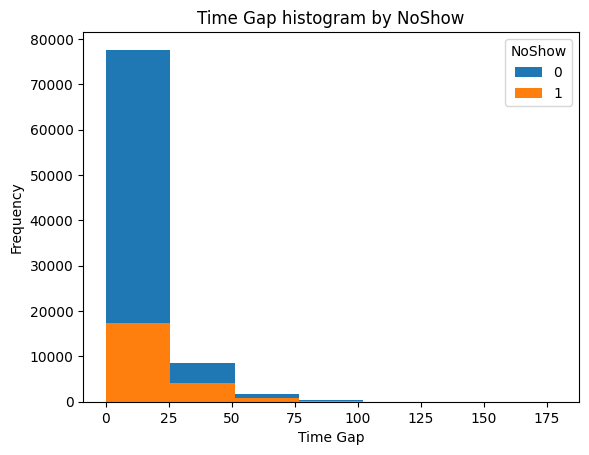

In [99]:
# time_gap histogram by NoShow 
df.pivot(columns='NoShow').time_gap.plot.hist(bins = 7)

plt.title('Time Gap histogram by NoShow')
plt.xlabel("Time Gap");

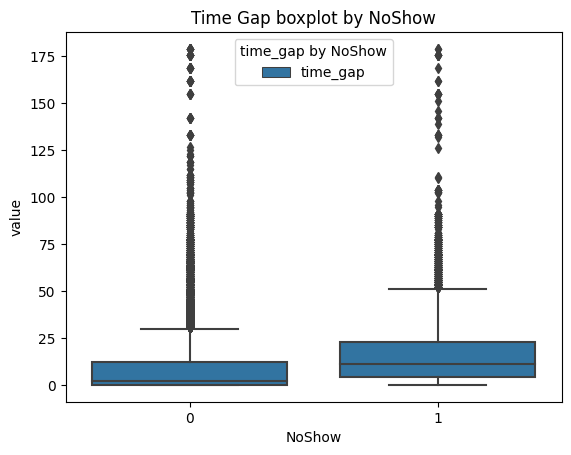

In [100]:
# Boxplot time_gap by Noshow
df_time_gap=pd.melt(df,id_vars=['NoShow'],value_vars=['time_gap'],var_name='time_gap by NoShow')
sns.boxplot(x='NoShow',y='value',data=df_time_gap,hue='time_gap by NoShow')

plt.title('Time Gap boxplot by NoShow');

In [101]:
mutual_info_classif(X= np.array(df['time_gap']).reshape(-1, 1) , y = np.array(df['NoShow']), discrete_features=[True])

array([0.05205242])

Most often patients book appointment within 25 days. First, second and third percentiles are lower among group that show on the booked appointment. Mutual information between Age column and target variable (NoShow) is above zero, therefore I conclude that there is mutual dependence between those two variables. 

### 4.  What are top 3 factors influencing no shows among numeric factors?

To select top 3 factors I will calculate mutual information between target variable and features. 
Source:
https://www.blog.trainindata.com/mutual-information-with-python/

In [102]:
y = np.array(df['NoShow'])

In [103]:
# X= np.array(df[['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']]).reshape(-1, 1)
X= df[['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']]

In [104]:
# which factors are discrete:
discrete_vars = [True, True, True, True, True, True, True, True]

In [105]:
mi = mutual_info_classif(X, y, discrete_features=discrete_vars)

In [106]:
mi

array([8.49255146e-06, 4.57862928e-03, 4.09351159e-04, 6.55994675e-04,
       1.18267429e-04, 1.92267831e-08, 3.25183312e-05, 7.70146001e-03])

In [107]:
def make_graph(pd_series, X, y_label, graph_title):
    '''
    pd_series - array of values
    X - data frame
    y_label -  string, y label for graph
    graph_title - string, graph title
    
    '''
    pd_series = pd.Series(pd_series)
    pd_series.index = X.columns
    pd_series.sort_values(ascending=False).plot.bar(figsize=(10, 5))
    
    plt.ylabel(y_label)
    plt.title(graph_title);

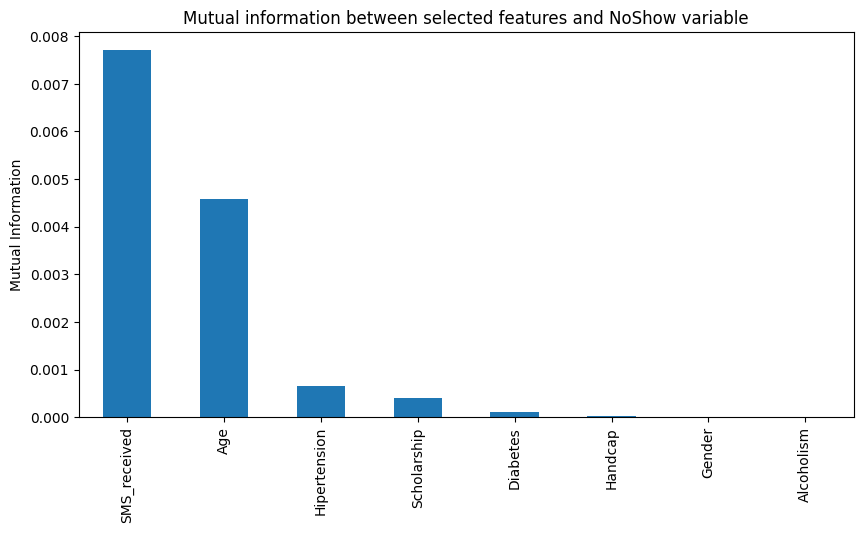

In [108]:
make_graph(pd_series = mi, X = X, y_label = 'Mutual Information', graph_title = 'Mutual information between selected features and NoShow variable')

In [109]:
# Base logit model to check feature importance
# add contant
X = sm.tools.tools.add_constant(X, prepend=True, has_constant='skip')

logr = sm.Logit(y, X).fit() 

Optimization terminated successfully.
         Current function value: 0.493034
         Iterations 6


In [110]:
print(logr.summary()) 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               110527
Model:                          Logit   Df Residuals:                   110518
Method:                           MLE   Df Model:                            8
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:                 0.01995
Time:                        14:20:32   Log-Likelihood:                -54494.
converged:                       True   LL-Null:                       -55603.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.4025      0.018    -78.234      0.000      -1.438      -1.367
Gender           0.0182      0.016      1.119      0.263      -0.014       0.050
Age             -0.0066      0.000    -16.74

In [111]:
X.drop(['Gender' , 'Handcap'], axis = 1, inplace = True) 

In [112]:
# I remove 'Gender' and 'Handcap' as p-value is above 0.1
logr = sm.Logit(y, X).fit() 

Optimization terminated successfully.
         Current function value: 0.493041
         Iterations 6


In [113]:
print(logr.summary()) 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               110527
Model:                          Logit   Df Residuals:                   110520
Method:                           MLE   Df Model:                            6
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:                 0.01994
Time:                        14:20:38   Log-Likelihood:                -54494.
converged:                       True   LL-Null:                       -55603.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3927      0.016    -88.332      0.000      -1.424      -1.362
Age             -0.0065      0.000    -16.723      0.000      -0.007      -0.006
Scholarship      0.1881      0.024      7.74

In [114]:
# get standardized coefficients
coef = np.array(abs(np.std(X, 0)*logr.params.values))

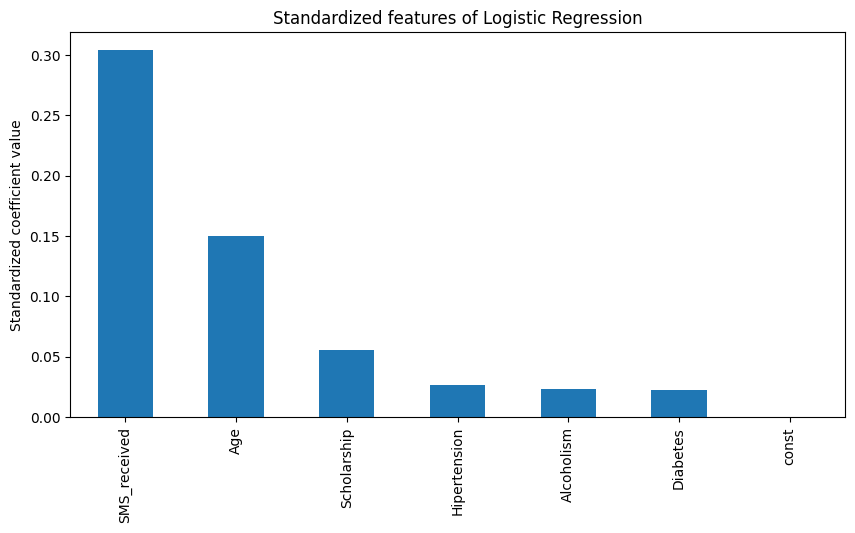

In [115]:
make_graph(pd_series = coef, X = X, y_label = 'Standardized coefficient value', graph_title = 'Standardized features of Logistic Regression')

To answer the question which factors are top 3 influencing target variable I calculated mutual information and standardized coefficients from logistic regression model. Based on mutual information top 3 features are: SMS_received, Age and Hipertension. Based on Logistic Regression top 3 factors are: SMS_received, Age and Scholarship. 

<a id='conclusions'></a>
## Conclusions

To analyse No Shows I started with data wrangling phase. 

The dataset contains 110527 records. Minimum value for age is -1. I treat it as incorrect data and will replace with 0 value. Almost 10% of appointments are appointments within scholarship and near 205 of patients have hipertension. 7% of patients are diabetes and 3% of patients abuse alcohol or are addicted to alcohol. 32% of patients received an SMS. 2% of pateints are handicap people.

I decided to clean the dataset :
1. I changed ScheduledDay and AppointmentDay fromats into datatime formats, 
2. I deleted AppointmentID as I don't need it in the analysis. 
3. I changed Gender to binary 0/1 value. F = 1, M = 0
5. I renamed No-show as NoShow and changed it into binary 0/1 value.
6. I changed Age -1 value into 0 value
7. I changed Neighbourhood as category variable

Conclusions:

The highest no-show ratio is during the weekend on Saturdays. The second highest no-show ratio is on Fridays. The lowest number of appointments is on Saturday, during the weekend. Most ofetn patients schedule appointments on Wednesdays and Teusdays.

Histograms and boxplots for 'Age' factor grouped by 'NoShow' are similar. 'NoShow = 1' group mean is 34 years, first percentile is 16 years and third percentile is 51 years. 'NoShow =0' group statistics are similar and little higher: mean is equal to 37 years, first percentile is 18 years and third percentile is 55 years. I implemented simple logit model to check if 'Age' coefficient is statistically significant. P-value of 'Age' coefficent equals 0, we may conclude that 'Age' has impact on 'NoShow' factor.
    
Most often patients book appointment within 25 days. First, second and third percentiles are lower among group that show on the booked appointment. Mutual information between Age column and target variable (NoShow) is above zero, therefore I conclude that there is mutual dependence between those two variables.

To answer the question which factors are top 3 influencing target variable I calculated mutual information and standardized coefficients from logistic regression model. Based on mutual information top 3 features are: SMS_received, Age and Hipertension. Based on Logistic Regression top 3 factors are: SMS_received, Age and Scholarship.

It would be interesting to check if hour of the appointment is significant when analysing NoShows, perhaps early mornings or late evening appointments are often skipped.

One limitation of the analysis is that additional features could be calculated from dataset. For example it would be useful to check the rate of NoShows for each patient. To analyse NoShows it would also be useful to adapt few ML models, split dataset into train, test and validation and check which factors are most important in each model.


## Submitting your Project 


In [116]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Investigate_a_Dataset.ipynb

[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 660418 bytes to Investigate_a_Dataset.html
